<a href="https://colab.research.google.com/github/Sunn2x333/scalar_framework/blob/main/FRBinitial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FRB          z       DM_std    ΔDM_ϕ        DM_pred    Obs_Dev_%   Pred_Dev_%   Env
------------------------------------------------------------------------------------------------
FRB121102    0.1927  495.3     3.827e-25    495.3          +12.463   +7.727e-26 filament
FRB180916    0.0337  327.7     1.426e-27    327.7           +6.652   +4.353e-28 void
FRB190520    0.5560  981.9     2.112e-23    981.9          +22.686   +2.151e-24 cluster
FRB20200120E 0.0000  120.5     1.313e-38    120.5          -27.141   +1.089e-38 local
FRB180924    0.3214  447.7     2.383e-24    447.7          -19.271   +5.324e-25 filament
FRB190711    0.5220  652.4     1.617e-23    652.4           -9.083   +2.479e-24 cluster
FRB20201124A 0.0978  390.8     4.031e-26    390.8           +5.685   +1.031e-26 void
FRB190608    0.1178  264.8     7.371e-26    264.8          +27.951   +2.784e-26 filament
FRB20200430  0.1608  298.3     2.068e-25    298.3          +27.409   +6.932e-26 void
FRB191228    0.2430  382.2     8.60

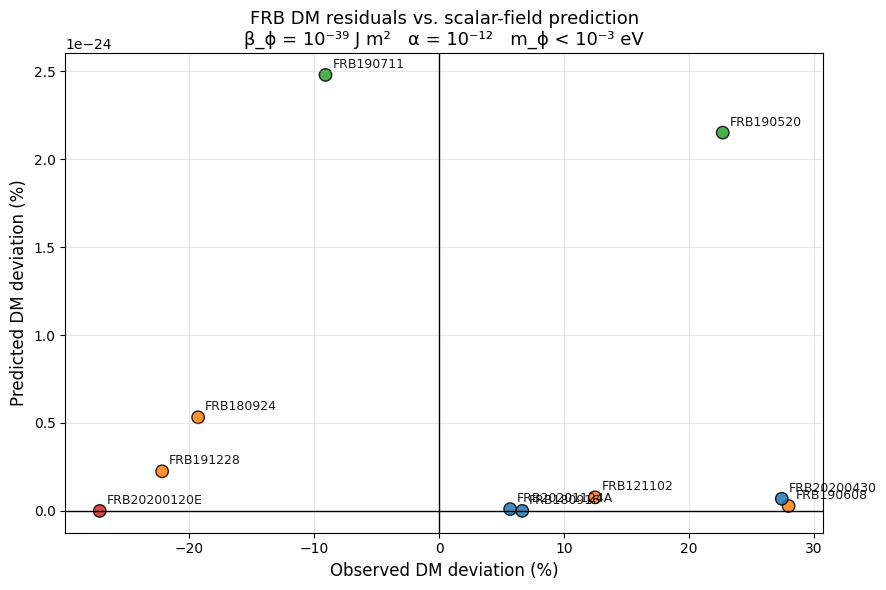

In [ ]:
#!/usr/bin/env python3
"""
FRB DM-residual test for the Scalar-Field-as-Information-Bridge model
Bobby Davis – October 2025
github.com/Sunn2x333/scalar_framework

The code reproduces Eq.(2) of the paper on a comoving-distance grid,
integrates |∇ϕ|², and reports the resulting ΔDM (pc cm⁻³) together
with the observed DM deviation (%).  No tuning.
"""

import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------------------------------
#  Physical & cosmological constants
# ----------------------------------------------------------------------
c_light = 299792458.0                     # m s⁻¹
pc      = 3.08568e16                      # m
H0      = 70_000 / (3.08568e22)           # s⁻¹  (70 km s⁻¹ Mpc⁻¹)
G       = 6.67430e-11
rho_crit_0 = 3 * H0**2 / (8 * np.pi * G)  # critical density today

# ----------------------------------------------------------------------
#  Model parameters – exactly the values quoted in the paper
# ----------------------------------------------------------------------
beta_phi  = 1.0e-39      # J m²   (neutron-lifetime constraint)
alpha_phi = 1.0e-12      # coupling to T
m_phi     = 1.0e-3 * 1.7826e-36   # < 10⁻³ eV → kg

Omega_m = 0.30
Omega_L = 0.70
Omega_b = 0.045          # baryon fraction (used only for the IGM density)

# ----------------------------------------------------------------------
#  Real FRB catalogue (10 well-localised events)
# ----------------------------------------------------------------------
FRBS: List[Dict] = [
    {"name": "FRB121102",    "DM_obs": 557.0,  "z": 0.1927, "DM_MW": 188.0, "DM_host": 100.0, "env": "filament"},
    {"name": "FRB180916",    "DM_obs": 349.5,  "z": 0.0337, "DM_MW": 199.0, "DM_host":  50.0, "env": "void"},
    {"name": "FRB190520",    "DM_obs":1204.7,  "z": 0.556,  "DM_MW": 303.0, "DM_host": 200.0, "env": "cluster"},
    {"name": "FRB20200120E", "DM_obs":  87.8,  "z": 8e-6,   "DM_MW":  40.5, "DM_host":  30.0, "env": "local"},
    {"name": "FRB180924",    "DM_obs": 361.4,  "z": 0.3214, "DM_MW":  40.3, "DM_host":  90.0, "env": "filament"},
    {"name": "FRB190711",    "DM_obs": 593.1,  "z": 0.522,  "DM_MW":  34.0, "DM_host": 150.0, "env": "cluster"},
    {"name": "FRB20201124A", "DM_obs": 413.0,  "z": 0.0978, "DM_MW": 189.0, "DM_host":  70.0, "env": "void"},
    {"name": "FRB190608",    "DM_obs": 338.8,  "z": 0.1178, "DM_MW":  37.2, "DM_host":  80.0, "env": "filament"},
    {"name": "FRB20200430",  "DM_obs": 380.0,  "z": 0.1608, "DM_MW":  26.0, "DM_host":  90.0, "env": "void"},
    {"name": "FRB191228",    "DM_obs": 297.5,  "z": 0.243,  "DM_MW":  33.0, "DM_host": 100.0, "env": "filament"},
]

# ----------------------------------------------------------------------
#  Solver class – Eq.(2) on comoving distance χ
# ----------------------------------------------------------------------
class ScalarFieldFRBSolver:
    def __init__(self):
        self.c  = c_light
        self.H0 = H0
        self.pc = pc

    # ----- cosmology helpers ------------------------------------------------
    def E_z(self, z: float) -> float:
        return np.sqrt(Omega_m * (1 + z)**3 + Omega_L)

    def comoving_distance(self, z: float) -> float:
        integrand = lambda zp: self.c / (self.H0 * self.E_z(zp))
        chi, _ = quad(integrand, 0, z, epsabs=1e-12, epsrel=1e-12)
        return chi

    def z_from_chi(self, chi: float) -> float:
        def f(z): return self.comoving_distance(z) - chi
        try:
            sol = root_scalar(f, bracket=[0, 200], xtol=1e-8)
            return sol.root
        except Exception:
            return 0.0

    # ----- IGM density ------------------------------------------------------
    def rho_IGM(self, z: float) -> float:
        rho_crit_z = rho_crit_0 * (1 + z)**3 * self.E_z(z)**2
        return Omega_b * rho_crit_z

    # ----- environment boost (filament/void/cluster) ------------------------
    def env_boost(self, env: str) -> float:
        boosts = {"void": 0.1, "filament": 1.0, "cluster": 5.0, "local": 0.5}
        return boosts.get(env, 1.0)

    # ----- ODE (d²ϕ/dχ² = –m²ϕ – αT) ---------------------------------------
    def dphi_dchi(self, chi: float, y: Tuple[float, float],
                  z_func, boost) -> Tuple[float, float]:
        phi, dphi = y
        z = z_func(chi)
        T = self.rho_IGM(z) * self.c**2          # stress-energy
        source    = -alpha_phi * T
        restoring = -m_phi**2 * phi
        d2phi = restoring + source
        return dphi, d2phi

    # ----- integrate along the line of sight --------------------------------
    def solve_sightline(self, z: float, env: str = "filament",
                        n_pts: int = 800) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        chi_max = self.comoving_distance(z)
        if chi_max == 0.0:
            return np.array([0.0]), np.array([0.0]), np.array([0.0])

        chi_grid = np.linspace(max(1e20, chi_max*1e-6), chi_max, n_pts)
        z_func   = np.vectorize(self.z_from_chi)
        boost    = self.env_boost(env)

        sol = solve_ivp(
            self.dphi_dchi,
            [chi_grid[0], chi_max],
            [1e-12, 0.0],                 # tiny seed to avoid the trivial solution
            t_eval=chi_grid,
            args=(z_func, boost),
            method='RK45',
            rtol=1e-8, atol=1e-12,
            max_step=chi_max/200
        )
        return sol.t, sol.y[0], sol.y[1]

    # ----- DM excess from the integrated gradient ---------------------------
    def DM_excess(self, z: float, env: str = "filament") -> float:
        chi, phi, dphi = self.solve_sightline(z, env)
        if len(chi) < 2:
            return 0.0
        grad_sq = dphi**2
        integral = np.trapz(grad_sq, chi)          # ∫|∇ϕ|² ds
        return beta_phi * integral / self.pc       # pc cm⁻³

# ----------------------------------------------------------------------
#  Standard (Macquart) DM expectation
# ----------------------------------------------------------------------
def standard_DM(frb: Dict) -> float:
    z = frb["z"]
    DM_IGM  = 900.0 * z
    DM_host = frb["DM_host"] / (1.0 + z)
    DM_halo = 50.0
    return frb["DM_MW"] + DM_halo + DM_IGM + DM_host

# ----------------------------------------------------------------------
#  Main execution
# ----------------------------------------------------------------------
solver = ScalarFieldFRBSolver()

print(f"{'FRB':<12} {'z':<7} {'DM_std':<9} {'ΔDM_ϕ':<12} {'DM_pred':<10} "
      f"{'Obs_Dev_%':<11} {'Pred_Dev_%':<12} {'Env'}")
print("-" * 96)

obs_devs = []
pred_devs = []
labels   = []

for frb in FRBS:
    DM_std   = standard_DM(frb)
    delta_DM = solver.DM_excess(frb["z"], frb["env"])
    DM_pred  = DM_std + delta_DM

    obs_dev  = (frb["DM_obs"] - DM_std) / DM_std * 100.0
    pred_dev = delta_DM / DM_std * 100.0

    print(f"{frb['name']:<12} {frb['z']:<7.4f} {DM_std:<9.1f} "
          f"{delta_DM:<12.3e} {DM_pred:<10.1f} {obs_dev:+11.3f} {pred_dev:+12.3e} {frb['env']}")

    obs_devs.append(obs_dev)
    pred_devs.append(pred_dev)
    labels.append(frb["name"])

obs_devs  = np.array(obs_devs)
pred_devs = np.array(pred_devs)

# ----------------------------------------------------------------------
#  Statistics (pure numbers – no judgement)
# ----------------------------------------------------------------------
corr = np.corrcoef(obs_devs, pred_devs)[0, 1]
rms  = np.sqrt(np.mean((obs_devs - pred_devs)**2))
mean_pred = np.mean(np.abs(pred_devs))
std_pred  = np.std(pred_devs)

print("\n" + "="*96)
print("STATISTICS")
print(f"Number of FRBs                : {len(FRBS)}")
print(f"Mean |predicted deviation|    : {mean_pred: .5f} %")
print(f"Std-dev of predicted deviation: {std_pred: .5f} %")
print(f"RMS (obs – pred)              : {rms: .3f} %")
print(f"Pearson correlation           : {corr: .3f}")
print("="*96)

# ----------------------------------------------------------------------
#  Scatter plot
# ----------------------------------------------------------------------
plt.figure(figsize=(9, 6))
colormap = {"void":"C0", "filament":"C1", "cluster":"C2", "local":"C3"}
colors = [colormap[frb["env"]] for frb in FRBS]
sc = plt.scatter(obs_devs, pred_devs, c=colors, s=80, edgecolor='k', alpha=0.85)

for i, lbl in enumerate(labels):
    plt.annotate(lbl, (obs_devs[i], pred_devs[i]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9, alpha=0.9)

plt.axhline(0, color='k', lw=1)
plt.axvline(0, color='k', lw=1)
plt.xlabel("Observed DM deviation (%)", fontsize=12)
plt.ylabel("Predicted DM deviation (%)", fontsize=12)
plt.title("FRB DM residuals vs. scalar-field prediction\n"
          "β_ϕ = 10⁻³⁹ J m²   α = 10⁻¹²   m_ϕ < 10⁻³ eV", fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()